In [1]:
import pandas as pd
import numpy as np
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math 
import seaborn as sns
import matplotlib.colors as mcolors
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.formula.api import mixedlm
import os
from scipy.stats import pearsonr

colors = list(mcolors.TABLEAU_COLORS.keys())*2

parentDirectory = os.path.abspath(os.path.join(os.path.join(os.getcwd(), os.pardir), os.pardir))
DATA_DIR = parentDirectory +'/data/'
FIGURES_DIR = parentDirectory +'/figures/'

df_agg = pd.read_pickle(DATA_DIR+'modes_coarse.pickle')

full_names = {
    'AU': 'Australia',
    'BR': 'Brazil',
    'CA': 'Canada',
    'FR': 'France',
    'DE': 'Germany',
    'IN': 'India',
    'IT': 'Italy',
    'MX': 'Mexico',
    'ES': 'Spain',
    'GB': 'United Kingdom',
    'US': 'United States',
    'DK': 'Denmark'
}

event_dicts = [{'country': 'AU',
  'start_md_1': '2020-03-27',
  'end_md_1': '2020-06-07',
  'start_md_2': np.nan},
 {'country': 'BR',
  'start_md_1': '2020-03-23',
  'end_md_1': '2020-08-09',
  'start_md_2': np.nan},
 {'country': 'CA',
  'start_md_1': '2020-03-19',
  'end_md_1': '2020-06-21',
  'start_md_2': '2020-10-12'},
 {'country': 'DE',
  'start_md_1': '2020-03-21',
  'end_md_1': '2020-05-09',
  'start_md_2': '2020-12-18'},
 {'country': 'DK',
  'start_md_1': '2020-03-17',
  'end_md_1': '2020-05-07',
  'start_md_2': np.nan},
 {'country': 'ES',
  'start_md_1': '2020-03-17',
  'end_md_1': '2020-06-14',
  'start_md_2': '2020-11-07'},
 {'country': 'FR',
  'start_md_1': '2020-03-18',
  'end_md_1': '2020-06-08',
  'start_md_2': '2020-11-01'},
 {'country': 'GB',
  'start_md_1': '2020-03-23',
  'end_md_1': '2020-08-03',
  'start_md_2': '2020-10-21'},
 {'country': 'IN',
  'start_md_1': '2020-03-24',
  'end_md_1': '2020-10-29',
  'start_md_2': np.nan},
 {'country': 'IT',
  'start_md_1': '2020-03-11',
  'end_md_1': '2020-06-06',
  'start_md_2': '2020-11-06'},
 {'country': 'JP',
  'start_md_1': '2020-04-12',
  'end_md_1': '2020-05-30',
  'start_md_2': np.nan},
 {'country': 'KE',
  'start_md_1': '2020-03-24',
  'end_md_1': '2020-10-04',
  'start_md_2': np.nan},
 {'country': 'MX',
  'start_md_1': '2020-03-25',
  'end_md_1': '2020-10-06',
  'start_md_2': np.nan},
 {'country': 'NG',
  'start_md_1': '2020-03-27',
  'end_md_1': '2020-08-09',
  'start_md_2': np.nan},
 {'country': 'US',
  'start_md_1': '2020-03-21',
  'end_md_1': '2020-06-11',
  'start_md_2': '2020-11-26'}]

df_events = pd.DataFrame(event_dicts)

df_events['start_md_1'] = pd.to_datetime(df_events['start_md_1'])
df_events['end_md_1'] = pd.to_datetime(df_events['end_md_1'])
df_events['start_md_2'] = pd.to_datetime(df_events['start_md_2'])

In [2]:
second_wave_countries = []

for i in event_dicts:
    if type(i['start_md_2'])==str:
        second_wave_countries.append(i['country'])
        
df_agg = df_agg.loc[(df_agg['country'].isin(second_wave_countries)) & (df_agg['country']!='DE')]

In [3]:
weeks_2019 = list(df_agg.iloc[0]['volume_weekly_total'].index)[:52]
weeks_2020 = list(df_agg.iloc[0]['volume_weekly_total'].index)[52:]

In [4]:
l = []
for cnt, row in df_agg.iterrows():
    start_md = df_events.loc[df_events['country'] == row['country']].iloc[0]['start_md_1']
    end_md = df_events.loc[df_events['country'] == row['country']].iloc[0]['end_md_1']
    start_md2 = df_events.loc[df_events['country'] == row['country']].iloc[0]['start_md_2']
    
    for week in zip(row['volume_weekly_total'].index,row['volume_weekly_total'].values,row['volume_percent_weekly_total'].values):
        
        entry = {}

        entry['country'] = row['country']
        entry['category'] = row['category']
        

        if week[0] in weeks_2020:
            date = pd.to_datetime(week[0])

            entry['k'] = math.floor(((date - start_md2).days +7) / 7)
            entry['volume_total'] = week[1]
            entry['volume_percent'] = week[2]
            entry['year'] = '2020'
            l.append(entry)

        elif week[0] in weeks_2019:
            date = pd.to_datetime(weeks_2020[weeks_2019.index(week[0])])
        

            entry['k'] = math.floor(((date - start_md2).days +7) / 7)
            entry['volume_total'] = week[1]
            entry['volume_percent'] = week[2]
            entry['year'] = '2019'
            l.append(entry)

In [5]:
df = pd.DataFrame(l)
df = df.loc[(df['k'] >= -30) & (df['k'] <= 30)].copy()
df['intervention_flag'] = df['k'].apply(lambda x: 1 if x >= 0 else 0)

In [6]:
#helpers

def generate_equation(order):
    if order == 'Cubic':
        eq = "volume_total ~ intervention_flag*k*year + intervention_flag*np.power(k,2)*year + intervention_flag*np.power(k,3)*year"
    elif order == "Quadratic":
        eq = "volume_total ~ intervention_flag*k*year + intervention_flag*np.power(k,2)*year"
    elif order == "Linear":
        eq = "volume_total ~ intervention_flag*k*year"
    elif order == 'Constant':
        eq = "volume_total ~ intervention_flag*year"
    return eq
    
def generate_equation_interactions(order):
    if order == 'Cubic':
        eq = "volume_total ~ intervention_flag*k*year*C(country)*C(category) + intervention_flag*np.power(k,2)*year*C(country)*C(category) + intervention_flag*np.power(k,3)*year*C(country)*C(category)"
    elif order == "Quadratic":
        eq = "volume_total ~ intervention_flag*k*year*C(country)*C(category) + intervention_flag*np.power(k,2)*year*C(country)*C(category)"
    elif order == "Linear":
        eq = "volume_total ~ intervention_flag*k*year*C(country)*C(category)"
    elif order == 'Constant':
        eq = "volume_total ~ intervention_flag*year*C(country)*C(category)"
    return eq

def get_standard_error_sum(covariates):
    '''
    #95CI is approximated with +- 2 sum_variance_standard_error
    '''
    
    #get the variance covariance matrix
    vcov = result_interactions.cov_params()\
        .loc[covariates,covariates].values
    
    #calculate the sum of all pair wise covariances by summing up
    m_sum = np.sum(vcov)
    
    #variance of a sum of variables is the square root
    return np.sqrt((m_sum))

In [7]:
k=30
df_temp = df.loc[(df['k'] >= -k) & (df['k'] <= k)].copy()
df_temp['volume_total'] = df_temp['volume_total'].apply(np.log)
mod = smf.ols(generate_equation_interactions('Quadratic'), data = df_temp)
result_interactions = mod.fit(cov_type='hc0')

In [8]:
cats = ['Mode 1','Mode 2','Mode 3','Mode 4']

In [9]:
default_country = 'CA'
default_category = 'Mode 1'

alpha_baseline = 'intervention_flag:year[T.2020]'
beta_baseline = 'intervention_flag:k:year[T.2020]'
gamma_baseline = 'intervention_flag:np.power(k, 2):year[T.2020]'

list_results = []



for country in second_wave_countries:
    if country =='DE':
        continue
    for c in cats:
        
        entry = {}
        entry['country']  = country
        entry['category'] = c
        
        suffix_country = (':C(country)[T.'+country+']')
        suffix_category = (':C(category)[T.'+c+']')
        
        if country == default_country and c == default_category:
            
            total_alpha = (result_interactions.params[alpha_baseline])
            total_alpha_error = (result_interactions.bse[alpha_baseline])
            
            total_beta = (result_interactions.params[beta_baseline])
            total_beta_error = (result_interactions.bse[beta_baseline])
            
            total_gamma = (result_interactions.params[gamma_baseline])
            total_gamma_error = (result_interactions.bse[gamma_baseline])
            
        elif country == default_country and c != default_category:
            
            total_alpha = (result_interactions.params[alpha_baseline]) \
                    + (result_interactions.params[alpha_baseline + suffix_category]) 
            total_alpha_error = (get_standard_error_sum([alpha_baseline, 
                                                         alpha_baseline + suffix_category]))
            
            total_beta = (result_interactions.params[beta_baseline]) \
                    + (result_interactions.params[beta_baseline + suffix_category]) 
            total_beta_error = (get_standard_error_sum([beta_baseline, 
                                                         beta_baseline + suffix_category]))
            
            total_gamma = (result_interactions.params[gamma_baseline]) \
                    + (result_interactions.params[gamma_baseline + suffix_category]) 
            total_gamma_error = (get_standard_error_sum([gamma_baseline, 
                                                         gamma_baseline + suffix_category]))

        elif country != default_country and c == default_category:
            
            total_alpha = (result_interactions.params[alpha_baseline]) \
                    + (result_interactions.params[alpha_baseline + suffix_country]) 
            total_alpha_error = (get_standard_error_sum([alpha_baseline,
                                                         alpha_baseline + suffix_country]))
            
            total_beta = (result_interactions.params[beta_baseline]) \
                    + (result_interactions.params[beta_baseline + suffix_country]) 
            total_beta_error = (get_standard_error_sum([beta_baseline,
                                                         beta_baseline + suffix_country]))
            
            total_gamma = (result_interactions.params[gamma_baseline]) \
                    + (result_interactions.params[gamma_baseline + suffix_country]) 
            total_gamma_error = (get_standard_error_sum([gamma_baseline,
                                                         gamma_baseline + suffix_country]))

        else:
            total_alpha = (result_interactions.params[alpha_baseline]) \
                    + (result_interactions.params[alpha_baseline + suffix_country]) \
                    + (result_interactions.params[alpha_baseline + suffix_category]) \
                    + (result_interactions.params[alpha_baseline + suffix_country + suffix_category])
            
            total_alpha_error = (get_standard_error_sum([alpha_baseline, 
                                                         alpha_baseline + suffix_category,
                                                         alpha_baseline + suffix_country, 
                                                         alpha_baseline + suffix_country + suffix_category]))
            
            total_beta = (result_interactions.params[beta_baseline]) \
                    + (result_interactions.params[beta_baseline + suffix_country]) \
                    + (result_interactions.params[beta_baseline + suffix_category]) \
                    + (result_interactions.params[beta_baseline + suffix_country + suffix_category])
            
            total_beta_error = (get_standard_error_sum([beta_baseline, 
                                                         beta_baseline + suffix_category,
                                                         beta_baseline + suffix_country, 
                                                         beta_baseline + suffix_country + suffix_category]))
            
            total_gamma = (result_interactions.params[gamma_baseline]) \
                    + (result_interactions.params[gamma_baseline + suffix_country]) \
                    + (result_interactions.params[gamma_baseline + suffix_category]) \
                    + (result_interactions.params[gamma_baseline + suffix_country + suffix_category])
            
            total_gamma_error = (get_standard_error_sum([gamma_baseline, 
                                                         gamma_baseline + suffix_category,
                                                         gamma_baseline + suffix_country, 
                                                         gamma_baseline + suffix_country + suffix_category]))
            
        entry['alpha'] = total_alpha
        entry['alpha_ste'] = total_alpha_error
        entry['beta'] = total_beta
        entry['beta_ste'] = total_beta_error
        entry['gamma'] = total_gamma
        entry['gamma_ste'] = total_gamma_error
        
        list_results.append(entry)
        
df_results = pd.DataFrame(list_results)

In [10]:
countries_sorted = list(df_results.loc[df_results['category'] == 'Mode 1'].\
                        sort_values(by = 'alpha', ascending = False)['country'].values)
cats_sorted = list(df_results.groupby('category')['alpha'].agg('mean').sort_values(ascending = False).index)


In [11]:
sorterIndex = dict(zip(countries_sorted, range(len(countries_sorted))))

def sort_pd(key=None,reverse=False):
    def sorter(series):
        series_list = list(series)
        return [series_list.index(i) 
           for i in sorted(series_list,key=key,reverse=reverse)]
    return sorter

sort_by_custom_dict = sort_pd(key=sorterIndex.get)

In [12]:
dict_annotate = {'Mode 1': 'Recipe, cooking, baking, grocery\n store, supermarket',
                 'Mode 2': 'Food delivery, take-out,\n drive-in', 
                 'Mode 3': 'Restaurant, careteria, cafe,\n diner, food festival', 
                 'Mode 4': 'Picnic, barbecue, \nlunchbox'}

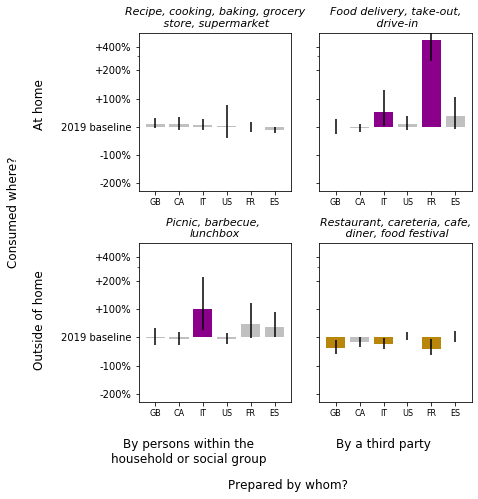

In [13]:
fig, axes = plt.subplots(2,2, figsize = (6,6), sharey = True)

for cnt,c in enumerate(['Mode 1','Mode 2','Mode 4','Mode 3']):
    sbplt = axes[math.floor(cnt/2), cnt%2]
    x = df_results.loc[df_results['category'] == c].iloc[sort_by_custom_dict(df_results.loc[df_results['category'] == c]['country'])][['alpha','country','alpha_ste']]
    
    colors_bars = []
    for i in range(6):
        if x['alpha'].values[i]>0 and x['alpha'].values[i]-2*x['alpha_ste'].values[i]>0:
            colors_bars.append('darkmagenta')
        elif x['alpha'].values[i]<0 and x['alpha'].values[i]+2*x['alpha_ste'].values[i]<0:
            colors_bars.append('darkgoldenrod')
        else:
            colors_bars.append('silver')
            
    #sbplt.bar(range(12),x['alpha'].apply(lambda x: np.exp(x)-1), yerr = 2*x['alpha_ste'].apply(lambda x: np.exp(x)-1), color = colors_bars)
    
    sbplt.bar(range(6),x['alpha'].apply(lambda x: np.exp(x)-1),
            #here we convert errors back to linear scale
            yerr = np.array([x['alpha'].apply(lambda x: np.exp(x)-1) - (x['alpha']-2*x['alpha_ste']).apply(lambda x: np.exp(x)-1),
                            (x['alpha']+2*x['alpha_ste']).apply(lambda x: np.exp(x)-1) - x['alpha'].apply(lambda x: np.exp(x)-1)]), 
            color = colors_bars)
    
    sbplt.set_xticks(range(6))
    
    sbplt.set_xticklabels(x['country'], fontsize= 8)
    sbplt.set_title(dict_annotate[c], size= 11, style='italic')
    
    #sbplt.set_yticks([-2,-1,0,1,2])
    #sbplt.set_yticklabels(["-200%","-100%","0","+100%","+200%"])
    sbplt.set_ylim([-2.5,6])
    
    sbplt.set_yscale('symlog', basey = 3)
    sbplt.set_yticks([-2,-1,0,1,2,4])
    sbplt.set_yticklabels(["-200%","-100%","2019 baseline","+100%","+200%","+400%"]) 

#fig.suptitle("α", position = (0.5, 1.05))

size_l = 12
fig.text(0.55, -0.14, 'Prepared by whom?', ha='center', fontsize= size_l)
fig.text(0.32, -0.08, 'By persons within the\nhousehold or social group', ha='center', fontsize= size_l)
fig.text(0.77, -0.08, 'By a third party\n', ha='center', fontsize= size_l)

fig.text(-0.1, 0.5, 'Consumed where?', va='center', rotation='vertical', fontsize= size_l)
fig.text(-0.04, 0.25, 'Outside of home', va='center', rotation='vertical', fontsize= size_l)
fig.text(-0.04, 0.75, 'At home', va='center', rotation='vertical', fontsize= size_l)
plt.tight_layout()

plt.savefig(FIGURES_DIR+"modes_second_wave.pdf", bbox_inches='tight')

In [14]:
dict_max_mobility = {'AU': ("2020-04-15", 21.714285714285715),
    'BR': ("2020-03-27",  20.857142857142858),
    'CA': ("2020-04-15",  23.285714285714285),
    'FR': ("2020-03-29",  30.428571428571427),
    'DE': ("2020-04-15",  17.428571428571427),
    'IN': ("2020-04-13",  29.142857142857142),
    'IT': ("2020-03-30",  31.571428571428573),
    'MX': ("2020-04-14",  21.142857142857142),
    'ES': ("2020-04-12",  31.428571428571427),
    'GB': ("2020-04-15",  25.714285714285715),
    'US': ("2020-04-09",  19.428571428571427),
    'DK': ("2020-03-23",  16.857142857142858)}

df_mobility_max = pd.DataFrame(dict_max_mobility)
df_mobility_max = df_mobility_max.transpose()
df_mobility_max = df_mobility_max.loc[(df_mobility_max.index.isin(second_wave_countries)) & (df_mobility_max.index!='DE')]

In [15]:
for cnt,c in enumerate(['Mode 1','Mode 2','Mode 4','Mode 3']):
    sbplt = axes[math.floor(cnt/2), cnt%2]
    x = df_results.loc[df_results['category'] == c][['alpha','country','alpha_ste']]
    x = x.set_index('country')
    df_mobility_max = df_mobility_max.join(x).rename(columns={"alpha": c+"_alpha", "alpha_ste": c+"_alpha_ste"})

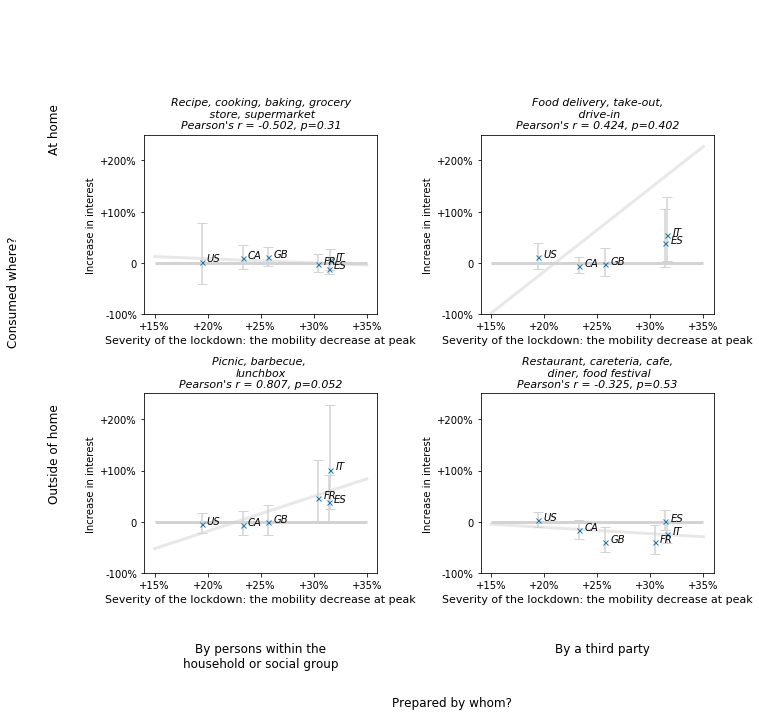

In [16]:
fig, axes = plt.subplots(2,2, figsize = (9.5,9), sharey = False, sharex = False)

for cnt,c in enumerate(['Mode 1','Mode 2','Mode 4','Mode 3']):
    sbplt = axes[math.floor(cnt/2), cnt%2]
    
    sbplt.set_xlabel('Severity of the lockdown: the mobility decrease at peak', fontsize = 11)
    
    
    sbplt.errorbar(df_mobility_max[1],df_mobility_max[c+'_alpha'].apply(lambda x: np.exp(x)-1),
           yerr = np.array([df_mobility_max[c+'_alpha'].apply(lambda x: np.exp(x)-1) - (df_mobility_max[c+'_alpha']-2*df_mobility_max[c+'_alpha_ste']).apply(lambda x: np.exp(x)-1),
                            (df_mobility_max[c+'_alpha']+2*df_mobility_max[c+'_alpha_ste']).apply(lambda x: np.exp(x)-1) - df_mobility_max[c+'_alpha'].apply(lambda x: np.exp(x)-1)]),
             linestyle ='none', capsize= 5, marker = 'x', markersize= 5, ecolor = 'lightgray')
    
    sbplt.hlines(0,15,35,color= 'lightgray',linewidth = 3)
   
    sbplt.set_yticks([-2,-1,0,1,2])
    sbplt.set_yticklabels(["-200%","-100%","0","+100%","+200%"])
    
    sbplt.set_xticks([15,20,25,30,35])
    sbplt.set_xticklabels(["+15%","+20%","+25%","+30%","+35%"])
    
    sbplt.set_ylabel('Increase in interest')
    for i in range(6):

        sbplt.annotate(df_mobility_max.index[i],
                 #dict_max_mobility[df_mobility_max.index[i]][0],
                 (df_mobility_max[1][i]+.5,df_mobility_max[c+'_alpha'].apply(lambda x: np.exp(x)-1)[i]), 
                 style = 'italic', fontsize = 10)
    sbplt.set_ylim([-1,2.5])
    
    m, b = np.polyfit(list(df_mobility_max[1].values), list(df_mobility_max[c+'_alpha'].apply(lambda x: np.exp(x)-1).values), 1)
    

    sbplt.set_title(dict_annotate[c]+\
                '\n'+'Pearson\'s r = '+str(round(pearsonr(df_mobility_max[1],df_mobility_max[c+'_alpha'].apply(lambda x: np.exp(x)-1))[0],3))+\
     ', p='+str(round(pearsonr(df_mobility_max[1],df_mobility_max[c+'_alpha'].apply(lambda x: np.exp(x)-1))[1],3)), size= 11, style='italic')

    if pearsonr(df_mobility_max[1],df_mobility_max[c+'_alpha'].apply(lambda x: np.exp(x)-1))[1] < 0.05:
        sbplt.plot((np.array(list(range(15,37,2)))), m*(np.array(list(range(15,37,2)))) + b, alpha = 0.5, linewidth = 3)
    else:
        sbplt.plot((np.array(list(range(15,37,2)))), m*(np.array(list(range(15,37,2)))) + b, alpha = 0.5, color = 'lightgray', linewidth = 3)

size_l = 12
fig.text(0.55, -0.14, 'Prepared by whom?', ha='center', fontsize= size_l)
fig.text(0.27, -0.08, 'By persons within the\nhousehold or social group', ha='center', fontsize= size_l)
fig.text(0.77, -0.08, 'By a third party\n', ha='center', fontsize= size_l)

fig.text(-0.1, 0.5, 'Consumed where?', va='center', rotation='vertical', fontsize= size_l)
fig.text(-0.04, 0.25, 'Outside of home', va='center', rotation='vertical', fontsize= size_l)
fig.text(-0.04, 0.75, 'At home', va='center', rotation='vertical', fontsize= size_l)
plt.tight_layout()

plt.savefig(FIGURES_DIR+"modes_severity_second_wave.pdf", bbox_inches='tight')